## 実験条件

- ネットワーク: ResNet18
- バッチ正規化：なし
- パラメータ：Fine tuning (訓練済みパラメータ有り)
- 拡散時間t=20, ビーズの数nBeads=100
- 作った隣接行列：1~9の各クラスで5000ずつ(訓練：5000x9-9000=36000 ，検証：500x9=4500，テスト：500x9=4500)

 ## テストの際Google Colabで利用するためのドライブのマウントなど

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My \Drive/source/dna-microscopy/2D/diffusion_deep_learning
%ls *.mtx

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/source/dna-microscopy/2D/diffusion_deep_learning
adjMatTargets.mtx  adjMatTargets_old.mtx  adjMatTargetsTest.mtx


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from scipy.io import mmread

plt.ion()   # interactive mode

# random seed
import random
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# GPUの使用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [3]:
# 訓練済みのResNet18モデルをロード
use_pretrained = True # 訓練済みのパラメータを使用しない
model = models.resnet18(pretrained=use_pretrained)

# 訓練モードに設定
model.train()
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [4]:
# ロードしたモデルの一部をタスクに合わせて変更
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # 入力層
model.fc = nn.Linear(in_features=512, out_features=9, bias=True)  # 出力層
# GPUデバイスにモデルを移動
model = model.to(device)

### 損失関数・最適化手法の設定

In [5]:
criterion = nn.CrossEntropyLoss()

# Fine Tuningを行うため，設定する学習率によって層を3つにグループ分けする
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

update_param_names_1 = ["conv1"]
update_param_names_2 = ["layer1", "layer2", "layer3", "layer4"]
update_param_names_3 = ["fc"]

for name, param in model.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param) 

    else:
        param.requires_grad = False

# weight_decayを使用するoptimizer
optimizer_ft = optim.Adam([
    {'params': params_to_update_1, 'lr': 1e-4, 'weight_decay': 4e-3},
    {'params': params_to_update_2, 'lr': 5e-4, 'weight_decay': 4e-3},
    {'params': params_to_update_3, 'lr': 1e-3, 'weight_decay': 4e-3},
])

def init_weights(m):  # Heの初期化
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.0)

if use_pretrained:
    optimizer = optimizer_ft
else:
    model.apply(init_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=4e-3)

## ネットワークを訓練する関数ネットワークを訓練する関数

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    accuracies = {"train": [], "val": []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # それぞれのエポックには訓練フェイズと検証フェイズがある
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルを訓練モードに
            else:
                model.eval()  # モデルを検証モードに

            running_loss = 0.0  # 各バッチでのロスの累積和
            running_corrects = 0  # 各バッチでの正解数の累積和

            # 未学習時の検証性能を確かめるため，epoch=0の訓練はskip
            #if (epoch == 0) and (phase == "train"):
            #    continue

            # dataloaderからバッチをとりだす
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device) - 1  ## 数字そのものをラベルにしているため1th indexedなのを0th indexedにする

                # 各層の勾配をゼロに初期化
                optimizer.zero_grad()

                # forward
                # 訓練時のみ勾配計算を行う
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)  # 各バッチでのロスを累積
                running_corrects += torch.sum(preds == labels.data)  # 各バッチでの正解数を累積

            epoch_loss = running_loss / dataset_sizes[phase]  # エポック全体でのロスの平均
            epoch_acc = running_corrects.double() / dataset_sizes[phase]  # エポック全体での正解率
            accuracies[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 検証フェイズでもっとも正解率が高かったときの正解率とモデルの重みパラメータを保存
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # もっとも正解率が高かったときのモデルを返す
    model.load_state_dict(best_model_wts)
    return model, accuracies

# 訓練データ，検証データでの精度の変遷を表示する関数
def show_trainval_acc(train_acc, val_acc):
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    x = np.arange(len(train_acc))
    plt.title('Accuracy')
    plt.plot(x, train_acc, label='train')
    plt.plot(x, val_acc, label='val')
    plt.legend()
    plt.show()

# ネットワークの予測精度を計算する関数
def check_accuracy(net):
    # Batch normalization や本節で実験を行う Dropout など訓練時と推論時(評価時)に挙動が変化する処理が存在します。
    # そのため一般的には推論前にネットワークを推論(評価)モードに切り替える必要があります。
    net.eval()  # ネットワークを評価状態へ切り替える
    ret = []
    with torch.no_grad():  #勾配計算をしない宣言(逆伝播用の計算グラフを作成しないことでメモリ節約、速度向上する)
        #for loader, name in [[trainloader, 'train'], [testloader, 'test']]:
        for loader, name in [[testloader, 'test']]:
            correct = 0
            total = 0
            for data in loader:
                images, labels = data[0].to(device), data[1].to(device) - 1  ## 1th indexed -> 0th indexed
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            ret.append(100 * correct / total)
            print('Accuracy of the network on the {} images: {:.2f} %'.format(name, ret[-1]))

    return ret

## データの読み込み，前処理・変換機，読み込み器

### データセットのクラス

In [7]:
#ToDo: 変換機の作成
#訓練データセットのクラス
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

"""
#検証データセットのクラス
class val_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)

#テストデータセットのクラス
class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, t_train):
        self.x_train = x_train
        self.t_train = t_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)
"""

'\n#検証データセットのクラス\nclass val_dataset(torch.utils.data.Dataset):\n    def __init__(self, x_train, t_train):\n        self.x_train = x_train\n        self.t_train = t_train\n\n    def __len__(self):\n        return self.x_train.shape[0]\n\n    def __getitem__(self, idx):\n        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)\n\n#テストデータセットのクラス\nclass test_dataset(torch.utils.data.Dataset):\n    def __init__(self, x_train, t_train):\n        self.x_train = x_train\n        self.t_train = t_train\n\n    def __len__(self):\n        return self.x_train.shape[0]\n\n    def __getitem__(self, idx):\n        return torch.tensor(self.x_train[idx], dtype=torch.float), torch.tensor(self.t_train[idx], dtype=torch.long)\n'

### データの読み込み

In [8]:
#データの読み込み
#amt.shape==(nSample * 9, nBeads**2 + 1), 最後の1列は各レコードのターゲットになっている

# プログラムが動くかどうかのテスト用の小さいデータ．shape=（5*9, 32*32 + 1）
#amt = mmread("adjMatTargetsTest.mtx").toarray()
#print(amt.shape)

# 本番用データ
amt = mmread("adjMatTargets.mtx").toarray()

data = amt[:,:-1]
nBeads = int(np.sqrt(data.shape[1]))

# vggを使うためデータのshapeを(nSmaple*9, 1, nBeads,nBeads)にする.第2次元はチャネル数に相当する．
data = data.reshape(data.shape[0], 1, nBeads, nBeads)
target = amt[:,-1]

#trainval_dataset = train_dataset(data[:-test_size,:], np.array(target[-test_size:],dtype=int))
data_dataset = train_dataset(data, np.array(target, dtype=int))

# 読み込んだデータをdatasetにしたものをtrain_dataset, val_dataset, test_datasetとに分割
val_rate, test_rate = 0.1, 0.1
val_size, test_size = int(len(data_dataset) * val_rate), int(len(data_dataset) * test_rate)
trainvalset, testset = torch.utils.data.random_split(data_dataset, [len(data_dataset)-test_size, test_size])
trainset, valset = torch.utils.data.random_split(trainvalset, [len(trainvalset)-val_size, val_size])

# 変換機
transform = transforms.ToTensor()
trainset.transform = transform
valset.transform = transform
testset.transform = transform

In [9]:
batch_size = 128 #一度に学習するデータ量
num_workers = 4

#訓練データのローダ(読み込み器)の作成
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, num_workers=num_workers
)

#検証データのローダ(読み込み器)の作成
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True, num_workers=num_workers
)

#テストデータのローダ(読み込み器)の作成
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=True, num_workers=num_workers
)

dataloaders = {'train': trainloader, 'val': valloader}
dataset_sizes = {'train': len(trainset), 'val': len(valset)}

## 学習

In [10]:
_, accs = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

Epoch 1/25
----------
train Loss: 2.3230 Acc: 0.1892
val Loss: 2.3680 Acc: 0.0000

Epoch 2/25
----------
train Loss: 1.6137 Acc: 0.4865
val Loss: 2.3975 Acc: 0.0000

Epoch 3/25
----------
train Loss: 1.2254 Acc: 0.7027
val Loss: 2.4336 Acc: 0.0000

Epoch 4/25
----------
train Loss: 1.0089 Acc: 0.8378
val Loss: 2.4856 Acc: 0.0000

Epoch 5/25
----------
train Loss: 0.8363 Acc: 0.9459
val Loss: 2.5866 Acc: 0.0000

Epoch 6/25
----------
train Loss: 0.6976 Acc: 0.9730
val Loss: 2.6716 Acc: 0.0000

Epoch 7/25
----------
train Loss: 0.5964 Acc: 1.0000
val Loss: 2.7051 Acc: 0.0000

Epoch 8/25
----------
train Loss: 0.5159 Acc: 1.0000
val Loss: 2.7422 Acc: 0.0000

Epoch 9/25
----------
train Loss: 0.4498 Acc: 1.0000
val Loss: 2.7832 Acc: 0.0000

Epoch 10/25
----------
train Loss: 0.3938 Acc: 1.0000
val Loss: 2.8634 Acc: 0.0000

Epoch 11/25
----------
train Loss: 0.3450 Acc: 1.0000
val Loss: 2.9872 Acc: 0.0000

Epoch 12/25
----------
train Loss: 0.3038 Acc: 1.0000
val Loss: 3.1436 Acc: 0.0000

E

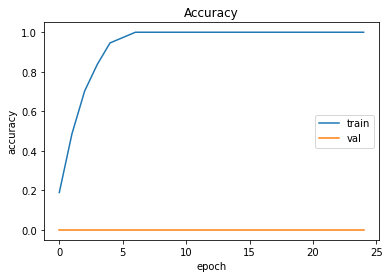

In [11]:
show_trainval_acc(accs["train"], accs["val"])

## テスト

In [12]:
acc = check_accuracy(model)

Accuracy of the network on the test images: 0.00 %
